In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
# sys.path.append('../../src/')
sys.path.append('../../src')
import stochastic_benchmark as SB
import numpy as np
import os
import bootstrap
import interpolate
import stats
from utils_ws import *
import pickle

In [3]:
here = os.getcwd()
parameter_names = ['iterations', 'shots', 'rounds'] # think about whether iterations should be a parameter or not.
instance_cols = ['instance'] #indicates how instances should be grouped, default is ['instance']

## Response information 
response_key = 'approx_ratio' # Column with the response
response_dir = 1 # whether we want to maximize (1) or minimize (-1), default is 1

## Optimizations informations
recover = True #Whether we want to read dataframes when available, default is True
reduce_mem = True #Whether we want to segment bootstrapping and interpolation to reduce memory usage, default is True
smooth = True  #Whether virtual best should be monontonized, default is True

sb = SB.stochastic_benchmark(parameter_names=parameter_names, here=here, instance_cols=instance_cols, response_key=response_key, response_dir=response_dir, smooth=smooth)

In [4]:
# Load Bootstrap data. 
# The data is already boostrapped, but needs to be loaded into memory
shared_args = {'response_col':"approx_ratio",
               'resource_col':"resource",
               'response_dir':1,
               'confidence_level':68}
boots_range = [1,2,5, 10, 20, 50, 100]
bsParams = bootstrap.BootstrapParameters(shared_args=shared_args, update_rule= lambda df: None)
bs_iter_class = bootstrap.BSParams_range_iter()
bsParams_iter = bs_iter_class(bsParams, boots_range)
sb.run_Bootstrap(bsParams_iter)

Found 10 bootstrapped results files and no raw data: reading results.


In [5]:
# Interpolate
def resource_fcn(df):
    return df['boots'] * df['iterations'] * df['shots']
iParams = interpolate.InterpolationParameters(resource_fcn,
                                              parameters=parameter_names)
sb.run_Interpolate(iParams)

d:\Dropbox\Academics\2022\Feynman Quantum Academy\Codes\local\dec-05-stoch-bench-add-qaoaexample\examples\QAOA_iterative\../../src\interpolate.py:43: UserWarning: Resource value type log does not support passing in values. Removing.
  warnings.warn(warn_str)


Interpolating results with parameters:  InterpolationParameters(resource_fcn=<function resource_fcn at 0x000001DE747B63B0>, parameters=['iterations', 'shots', 'rounds'], resource_value_type='log', resource_values=[], group_on='instance', min_boots=1, ignore_cols=[])


100%|██████████| 540/540 [00:01<00:00, 331.09it/s]


In [6]:
# Set up Stats computations
train_test_split = 0.5
metrics = ["approx_ratio"]
stParams = stats.StatsParameters(metrics=metrics, stats_measures=[stats.Median()])
sb.run_Stats(stParams, train_test_split)

Computing training stats


100%|██████████| 20895/20895 [00:04<00:00, 4464.73it/s]


In [7]:
sb.run_baseline()

Runnng baseline


In [8]:
sb.run_ProjectionExperiment('TrainingStats', None, None)
sb.run_ProjectionExperiment('TrainingResults', None, None)

Running projection experiment
Evaluating recommended parameters on testing results
Running projection experiment
Evaluating recommended parameters on testing results


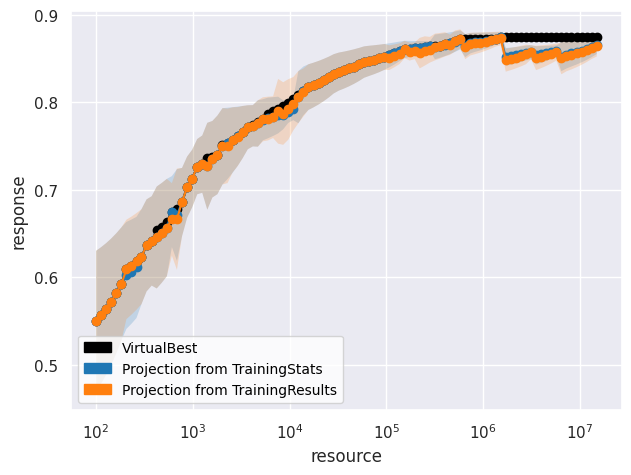

In [9]:
sb.initPlotting()
p = sb.plots.plot_performance()
ax = p.axes[0]
p.savefig('performance.png')

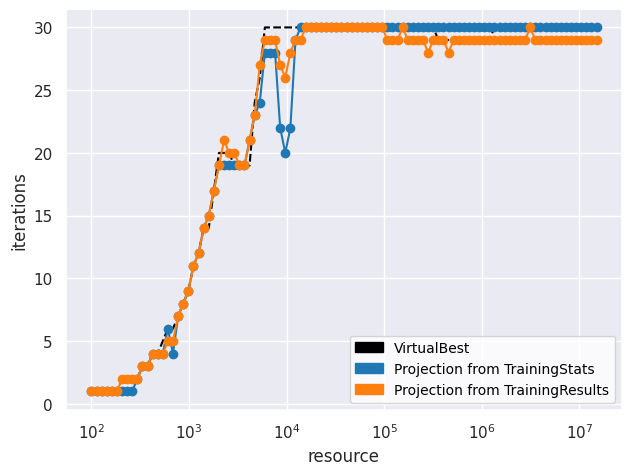

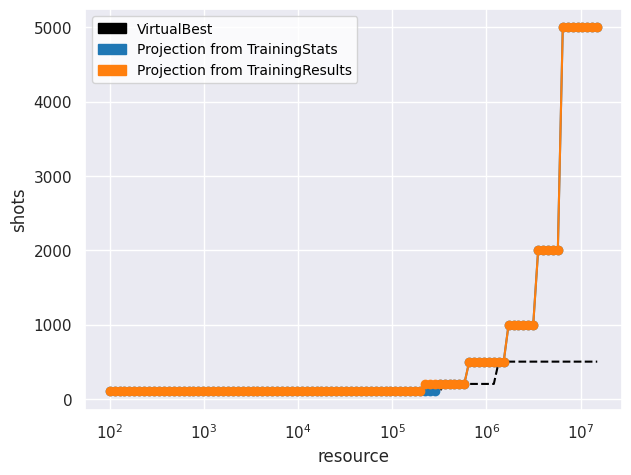

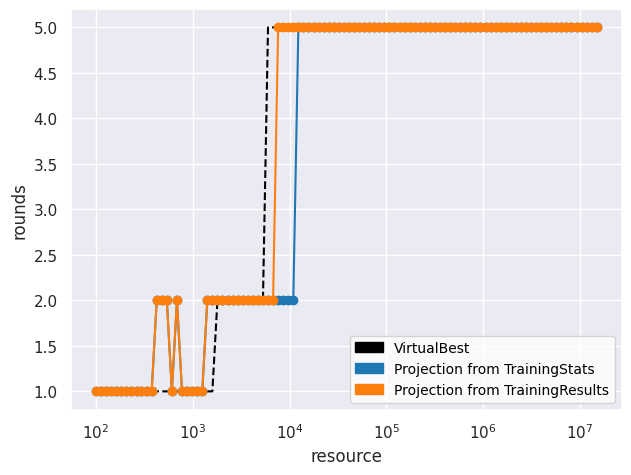

In [10]:
p_dict = sb.plots.plot_parameters()
for k, p in p_dict.items():
    p.savefig('Recommended_parameter={}_scale={}.png'.format(k, sb.plots.xscale))

In [ ]:
assert 1 == 2, "stop here"